In [30]:
import findspark
findspark.init()

import sys
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('Transport_Data').getOrCreate()

In [3]:
stops_df       = spark.read.csv('stops.txt',      header=True, inferSchema=True, sep=',')
stops_times_df = spark.read.csv('stop_times.txt', header=True, inferSchema=True, sep=',')
trips_df       = spark.read.csv('trips.txt',      header=True, inferSchema=True, sep=',')
routes_df      = spark.read.csv('routes.txt',     header=True, inferSchema=True, sep=',')
calender_df    = spark.read.csv('calendar.txt',   header=True, inferSchema=True, sep=',')
directions_df  = spark.read.csv('directions.txt', header=True, inferSchema=True, sep=',')

stops_df.createOrReplaceTempView("stops")
stops_times_df.createOrReplaceTempView("stops_times")
trips_df.createOrReplaceTempView("trips")
routes_df.createOrReplaceTempView("routes")
calender_df.createOrReplaceTempView("calender")
directions_df.createOrReplaceTempView("directions")

### Data Transformation, combining various datasets together

In [4]:
service_joined_data = spark.sql("""
SELECT stops.stop_id, stops.stop_code, stops.stop_name, stops.stop_lat, stops.stop_lon, stops.zone_id, stops.location_type,
       stops_times.trip_id, stops_times.arrival_time, stops_times.departure_time, stops_times.stop_sequence,
       stops_times.pickup_type, stops_times.drop_off_type, stops_times.shape_dist_traveled,
       trips.route_id, trips.service_id, trips.trip_headsign, trips.trip_short_name, trips.direction_id, 
       trips.block_id, trips.shape_id, trips.wheelchair_accessible, trips.bikes_allowed,
       routes.agency_id,routes.route_short_name,routes.route_long_name,routes.route_type,
       directions.direction,
       calender.monday,calender.tuesday,calender.wednesday,calender.thursday,calender.friday,
       calender.saturday,calender.sunday,calender.start_date,calender.end_date
FROM stops
LEFT JOIN stops_times ON stops.stop_id = stops_times.stop_id
LEFT JOIN trips ON stops_times.trip_id = trips.trip_id
LEFT JOIN routes ON trips.route_id = routes.route_id
LEFT JOIN directions ON trips.route_id = directions.route_id
LEFT JOIN calender ON trips.service_id = calender.service_id
""")
service_joined_data.createOrReplaceTempView("Complete_data")

In [5]:
Complete_routes = spark.sql("""SELECT trip_id,zone_id,
                                  arrival_time, departure_time,stop_id,stop_code,stop_name,stop_sequence, 
                                  stop_lat,stop_lon, route_id,route_long_name,direction,service_id,wheelchair_accessible,
                                  bikes_allowed,
                                  monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date 
                                  from Complete_data where trip_id is not null and route_id is not null """)
    
Complete_routes.createOrReplaceTempView("Transport_routes")

In [6]:
service_joined_data.count()

3551715

In [7]:
Complete_routes.count()

3551656

### Metrics to Understand Data

In [8]:
stops_per_route = spark.sql("""
SELECT route_id, route_long_name, direction, COUNT(DISTINCT stop_sequence) as num_stops
FROM Transport_routes
GROUP BY route_id,route_long_name,direction
ORDER BY num_stops DESC
""")
stops_per_route.show(10)

+--------+--------------------+---------+---------+
|route_id|     route_long_name|direction|num_stops|
+--------+--------------------+---------+---------+
|    6834|Downtown/Surrey C...|     EAST|       90|
|    6834|Downtown/Surrey C...|     WEST|       90|
|    6841|Downtown/Lougheed...|     WEST|       86|
|    6841|Downtown/Lougheed...|     EAST|       86|
|    6622|29th Avenue Stati...|     WEST|       80|
|    6622|29th Avenue Stati...|     EAST|       80|
|    6749|Haney/Maple Ridge...|     WEST|       69|
|    6749|Haney/Maple Ridge...|     EAST|       69|
|    6830|Downtown/Richmond...|    SOUTH|       68|
|    6830|Downtown/Richmond...|    NORTH|       68|
+--------+--------------------+---------+---------+
only showing top 10 rows



#### Wheelchair Accessibility Analysis

In [29]:
Wheelchair_Accessibility_trips = spark.sql("""SELECT distinct route_id,route_long_name,wheelchair_accessible, COUNT(*) AS num_trips
 FROM Transport_routes 
 GROUP BY route_id, route_long_name, wheelchair_accessible """)
Wheelchair_Accessibility_trips.show()

+--------+--------------------+---------------------+---------+
|route_id|     route_long_name|wheelchair_accessible|num_trips|
+--------+--------------------+---------------------+---------+
|    6619|Boundary/Commerci...|                    0|    46592|
|    6617|Nanaimo Station/D...|                    0|    55450|
|    6620|Granville/Waterfr...|                    0|    44376|
|   16718|        Hastings/UBC|                    0|    59980|
|    6615|     Robson/Downtown|                    0|    18786|
|    6614| Powell/Downtown/UBC|                    0|    40290|
|    6613|Main/Waterfront S...|                    0|    37128|
|    6616|      Davie/Downtown|                    0|    19446|
|    6618|Fraser/Waterfront...|                    0|    39982|
|    6622|29th Avenue Stati...|                    0|    77858|
|    6623|        Downtown/Oak|                    0|    31230|
|    6624|Metrotown Station...|                    0|    56552|
|    6621|Cambie/Olympic Vi...|         

#### Bikes_Allowed_Analysis

In [17]:
Bikes_allowed_trips = spark.sql("""SELECT route_id,route_long_name,bikes_allowed, COUNT(*) AS num_trips
 FROM Transport_routes
 GROUP BY route_id, route_long_name, bikes_allowed """)
Bikes_allowed_trips.show()

+--------+--------------------+-------------+---------+
|route_id|     route_long_name|bikes_allowed|num_trips|
+--------+--------------------+-------------+---------+
|    6617|Nanaimo Station/D...|            1|    55450|
|    6614| Powell/Downtown/UBC|            1|    40290|
|    6615|     Robson/Downtown|            1|    18786|
|    6620|Granville/Waterfr...|            1|    44376|
|    6616|      Davie/Downtown|            1|    19446|
|    6618|Fraser/Waterfront...|            1|    39982|
|   16718|        Hastings/UBC|            1|    59980|
|    6613|Main/Waterfront S...|            1|    37128|
|    6619|Boundary/Commerci...|            1|    46592|
|    6623|        Downtown/Oak|            1|    31230|
|    6626|     Knight/Downtown|            1|    46240|
|    6624|Metrotown Station...|            1|    56552|
|    6622|29th Avenue Stati...|            1|    77858|
|    6625|   Victoria/Downtown|            1|    51414|
|    6621|Cambie/Olympic Vi...|            1|   

#### Service Availability

In [24]:
serviceAvailability = spark.sql("""
SELECT SUM(monday) as monday_trips, SUM(tuesday) as tuesday_trips, SUM(wednesday) as wednesday_trips,
       SUM(thursday) as thursday_trips, SUM(friday) as friday_trips,
       SUM(saturday) as saturday_trips, SUM(sunday) as sunday_trips
FROM Transport_routes
""")
serviceAvailability.show() 

+------------+-------------+---------------+--------------+------------+--------------+------------+
|monday_trips|tuesday_trips|wednesday_trips|thursday_trips|friday_trips|saturday_trips|sunday_trips|
+------------+-------------+---------------+--------------+------------+--------------+------------+
|     1395806|      1395806|        1395806|       1395806|     1395806|       1106858|      970978|
+------------+-------------+---------------+--------------+------------+--------------+------------+



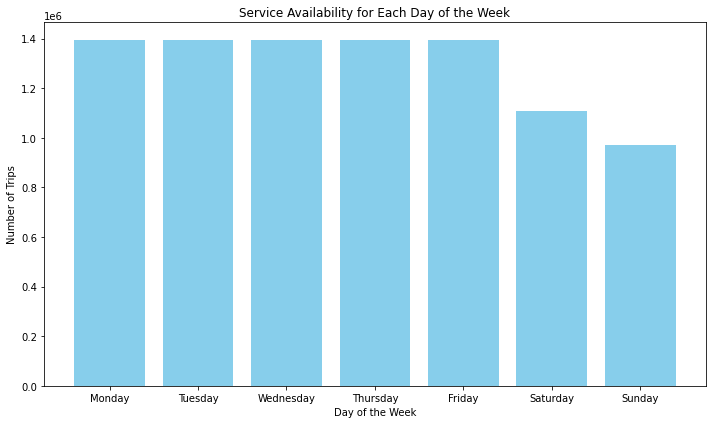

In [32]:
serviceAvailability_pandas = serviceAvailability.toPandas()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_counts = [
    serviceAvailability_pandas['monday_trips'].iloc[0],
    serviceAvailability_pandas['tuesday_trips'].iloc[0],
    serviceAvailability_pandas['wednesday_trips'].iloc[0],
    serviceAvailability_pandas['thursday_trips'].iloc[0],
    serviceAvailability_pandas['friday_trips'].iloc[0],
    serviceAvailability_pandas['saturday_trips'].iloc[0],
    serviceAvailability_pandas['sunday_trips'].iloc[0]
]

plt.figure(figsize=(10, 6))
plt.bar(days, trip_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Service Availability for Each Day of the Week')
plt.tight_layout()
plt.show()


#### Number of trips per route/direction

In [25]:
Trips_per_direction = spark.sql("""SELECT direction, COUNT(DISTINCT trip_id) AS num_trips
FROM Transport_routes
GROUP BY direction
""")
Trips_per_direction.show() 

+---------+---------+
|direction|num_trips|
+---------+---------+
|     WEST|    38466|
|    SOUTH|    21839|
|    NORTH|    21839|
|     EAST|    38466|
+---------+---------+



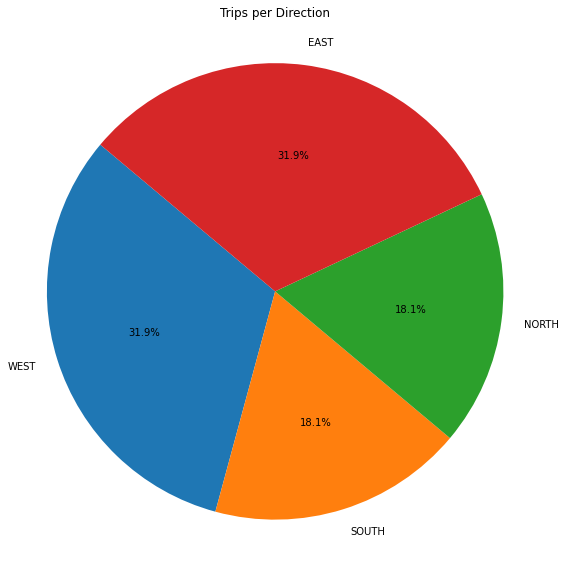

In [33]:
trips_per_direction_pandas = Trips_per_direction.toPandas()
directions = trips_per_direction_pandas['direction']
num_trips = trips_per_direction_pandas['num_trips']

plt.figure(figsize=(8, 8))
plt.pie(num_trips, labels=directions, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Trips per Direction')
plt.tight_layout()
plt.show()

#### Calculate stop density within a specific area

In [22]:
stopDensity = spark.sql("""
        SELECT zone_id, COUNT(stop_id) AS num_stops,
           COUNT(stop_id) / COUNT(DISTINCT zone_id) AS stop_density
    FROM Transport_routes
    GROUP BY zone_id
""")
stopDensity.show() 

+-------+---------+------------+
|zone_id|num_stops|stop_density|
+-------+---------+------------+
| BUS ZN|  3372074|   3372074.0|
|   ZN 1|    81760|     81760.0|
|   ZN 2|    70014|     70014.0|
|   ZN 3|    25006|     25006.0|
|  CL_AD|     2550|      2550.0|
|  WCE1Z|       24|        24.0|
|  WCE4Z|       24|        24.0|
|  WCE2Z|       72|        72.0|
|  WCE1A|       12|        12.0|
|  WCE2A|       48|        48.0|
|  WCE3Z|       72|        72.0|
+-------+---------+------------+



#### Analyze the distribution of stop frequencies

In [21]:
stopFrequency = spark.sql("""
SELECT stop_name, COUNT(*) AS frequency
FROM Transport_routes
GROUP BY stop_name
ORDER BY frequency DESC
""")
stopFrequency.show()

+--------------------+---------+
|           stop_name|frequency|
+--------------------+---------+
|Coquitlam Central...|     3906|
|UBC Exchange @ Un...|     3726|
|Waterfront Statio...|     3714|
|Westbound W Pende...|     3440|
|Northbound Granvi...|     3276|
|Northbound Granvi...|     3276|
|Northbound Granvi...|     3248|
|Marine Drive Stat...|     3084|
|Westbound E Hasti...|     3036|
|Westbound W Hasti...|     3036|
|Westbound W Pende...|     2930|
|Metrotown Station...|     2914|
|Eastbound W Pende...|     2788|
|Surrey Central St...|     2706|
|Eastbound W Cordo...|     2674|
|Metrotown Station...|     2562|
|Westbound 72 Ave ...|     2560|
|Main St @ Phibbs ...|     2528|
|Northbound Granvi...|     2440|
|Northbound Granvi...|     2440|
+--------------------+---------+
only showing top 20 rows



#### Analyze service availability throughout the day

In [20]:
temporalAvailability = spark.sql("""
SELECT HOUR(arrival_time) AS hour_of_day, COUNT(*) AS num_trips
FROM Transport_routes where HOUR(arrival_time) is not null
GROUP BY HOUR(arrival_time)
ORDER BY hour_of_day
""")
temporalAvailability.show(24)

+-----------+---------+
|hour_of_day|num_trips|
+-----------+---------+
|          3|      886|
|          4|     9130|
|          5|    61686|
|          6|   140872|
|          7|   182786|
|          8|   199752|
|          9|   195368|
|         10|   187466|
|         11|   186492|
|         12|   189046|
|         13|   193746|
|         14|   203228|
|         15|   224138|
|         16|   233500|
|         17|   232146|
|         18|   216432|
|         19|   186458|
|         20|   162978|
|         21|   147132|
|         22|   123698|
|         23|   104870|
+-----------+---------+

